# Dropout

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = scipy.io.loadmat('PlanarData.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:29:06 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-1.58986e-01,  4.23977e-01],
        [-3.47926e-01,  4.70760e-01],
        [-5.04608e-01,  3.53801e-01],
        [-5.96774e-01,  1.14035e-01],
        [-5.18433e-01, -1.72515e-01],
        [-2.92627e-01, -2.07602e-01],
        [-1.58986e-01, -4.38596e-02],
        [-5.76037e-02,  1.43275e-01],
        [-7.14286e-02,  2.71930e-01],
        [-2.97235e-01,  3.47953e-01],
        [-4.17051e-01,  2.01754e-01],
        [-4.40092e-01,  8.77193e-03],
        [-3.24885e-01, -3.21637e-02],
        [-2.46544e-01,  5.55556e-02],
        [-2.18894e-01,  2.01754e-01],
        [-3.43318e-01,  1.60819e-01],
        [-5.09217e-01,  7.89474e-02],
        [-3.84793e-01, -9.06433e-02],
        [-1.49770e-01,  1.25731e-01],
        [-1.95853e-01,  3.24561e-01],
        [-3.91705e-02, -2.19298e-01],
        [-1.08295e-01, -3.01170e-01],
        [-1.86636e-0

In [3]:
X_train = np.array(data['X'], dtype='float32')
Y_train = np.array(data['y'], dtype='float32')

X_test = np.array(data['Xval'], dtype='float32')
Y_test = np.array(data['yval'], dtype='float32')

X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

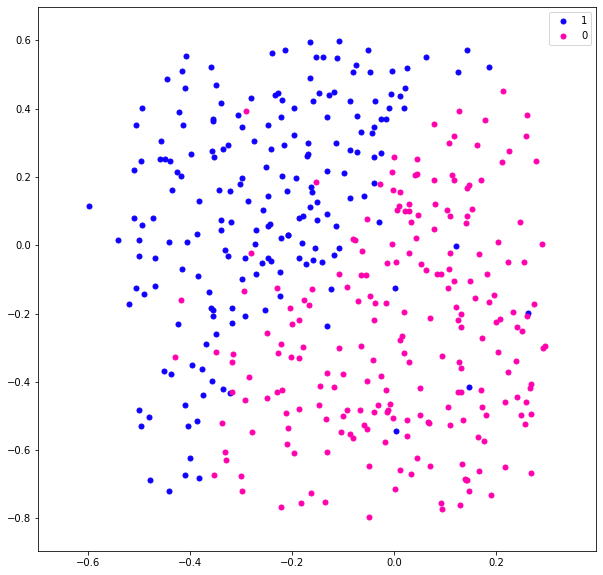

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, np.min(X[:,1])-0.1, np.max(X[:,1])+0.1])
pos = np.where(Y[:,0] == 1)[0]
neg = np.where(Y[:,0] == 0)[0]
ax.plot(X[pos,0], X[pos,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='1') 
ax.plot(X[neg,0], X[neg,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='0')
ax.legend()

In [5]:
class Layer1():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.maximum(0.,u)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim, keep_prob):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.keep_prob = keep_prob
        self.training = False
        self.build()
        
    def build(self):
        self.weights = []

    def __call__(self, inputs):
        if self.training:
            d = tf.random.uniform(shape=(1,inputs.shape[1]), dtype=tf.float32)
            u = tf.sign(1.+tf.sign(self.keep_prob-d))
            z = (1/self.keep_prob)*u*inputs
        else:
            z = inputs
        return z
    
class Layer4():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.sigmoid(u)

In [6]:
class LossFunction():
        
    def __init__(self, model):
        self.model = model
            
    def __call__(self, y_true, y_pred):
        return -tf.math.reduce_mean(y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred))

In [7]:
class MetricFunction():
        
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
            
    def __call__(self, y_true, y_pred):
        y_pred_ = tf.sign(1+tf.sign(y_pred-self.threshold))
        return tf.math.reduce_mean(1-tf.square(tf.sign(y_true-y_pred_))) 

In [8]:
class Optimizer():
    
    def __init__(self, model, learning_rate, batch_size):
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.stop_training = False
        
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            weights[i].assign(w - self.learning_rate*grad_w)
            
    def train_step(self, X, Y):        
        for i in range(2,len(self.model.layers),2):
            self.model.layers[i].training = True
        num_batches = X.shape[0]//self.batch_size
        for batch in range(num_batches+1):
            if batch<num_batches:
                X_batch = X[batch*self.batch_size:(batch+1)*self.batch_size,:]
                Y_batch = Y[batch*self.batch_size:(batch+1)*self.batch_size,:]
            else:
                X_batch = X[batch:,:]
                Y_batch = Y[batch:,:]
            with tf.GradientTape() as tape:
                H = self.model(X_batch)
                loss = self.model.loss(Y_batch, H)
            grads = tape.gradient(loss, self.model.weights)
            self.apply(grads, self.model.weights) 
        for i in range(2,len(self.model.layers),2):
            self.model.layers[i].training = False
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [9]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [10]:
class NN():
    
    def __init__(self, dims):
        self.dims = dims
        self.build()
        
    def build(self):
        self.layers = []        
        self.layers.append(Layer1(model=self, input_dim=self.dims[0], output_dim=self.dims[0]))
        for i in range(len(self.dims)-2):
            self.layers.append(Layer2(model=self, input_dim=self.dims[i], output_dim=self.dims[i+1]))
            self.layers.append(Layer3(model=self, input_dim=self.dims[i], output_dim=self.dims[i+1], keep_prob=0.85))
        self.layers.append(Layer4(model=self, input_dim=self.dims[-2], output_dim=self.dims[-1]))
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        y = inputs
        for layer in self.layers:
            y = layer(y)
        return y 
        
    def train_setup(self, epochs, learning_rate, batch_size, threshold, verbose):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.threshold = threshold
        self.verbose = verbose
        self.loss = LossFunction(model=self)
        self.metric = MetricFunction(model=self, threshold=self.threshold)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, batch_size=self.batch_size)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=1000, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=2000, error=0.001)]
        
    def fit(self, X, Y, epochs=1000, learning_rate=0.01, batch_size=32, threshold=0.5, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(epochs, learning_rate, batch_size, threshold, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break 
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [11]:
nn = NN(dims=[X_train.shape[1], 32, 32, Y_train.shape[1]])

nn.fit(X_train, Y_train)

Train on 211 samples
Epochs 1/1000 - Loss: 0.694956362247467 - Metric: 0.4976303279399872
----- 0.184s -----
Epochs 2/1000 - Loss: 0.694921612739563 - Metric: 0.4976303279399872
----- 0.061s -----
Epochs 3/1000 - Loss: 0.6948879957199097 - Metric: 0.4976303279399872
----- 0.044s -----
Epochs 4/1000 - Loss: 0.694857120513916 - Metric: 0.4976303279399872
----- 0.06s -----
Epochs 5/1000 - Loss: 0.6948297619819641 - Metric: 0.4976303279399872
----- 0.051s -----
Epochs 6/1000 - Loss: 0.6947973370552063 - Metric: 0.4976303279399872
----- 0.044s -----
Epochs 7/1000 - Loss: 0.6947662830352783 - Metric: 0.4976303279399872
----- 0.05s -----
Epochs 8/1000 - Loss: 0.6947377920150757 - Metric: 0.4976303279399872
----- 0.041s -----
Epochs 9/1000 - Loss: 0.6947036385536194 - Metric: 0.4976303279399872
----- 0.047s -----
Epochs 10/1000 - Loss: 0.6946665644645691 - Metric: 0.4976303279399872
----- 0.041s -----
Epochs 11/1000 - Loss: 0.6946398019790649 - Metric: 0.4976303279399872
----- 0.038s -----
Epo

----- 0.041s -----
Epochs 93/1000 - Loss: 0.6909456849098206 - Metric: 0.4976303279399872
----- 0.042s -----
Epochs 94/1000 - Loss: 0.6908730864524841 - Metric: 0.4976303279399872
----- 0.046s -----
Epochs 95/1000 - Loss: 0.6907919049263 - Metric: 0.4976303279399872
----- 0.043s -----
Epochs 96/1000 - Loss: 0.6907280087471008 - Metric: 0.4976303279399872
----- 0.043s -----
Epochs 97/1000 - Loss: 0.6906638741493225 - Metric: 0.4976303279399872
----- 0.039s -----
Epochs 98/1000 - Loss: 0.6905801892280579 - Metric: 0.4976303279399872
----- 0.037s -----
Epochs 99/1000 - Loss: 0.6905050873756409 - Metric: 0.4976303279399872
----- 0.039s -----
Epochs 100/1000 - Loss: 0.6904277801513672 - Metric: 0.4976303279399872
----- 0.04s -----
Epochs 101/1000 - Loss: 0.6903579235076904 - Metric: 0.4976303279399872
----- 0.038s -----
Epochs 102/1000 - Loss: 0.6902725696563721 - Metric: 0.4976303279399872
----- 0.036s -----
Epochs 103/1000 - Loss: 0.6902056336402893 - Metric: 0.4976303279399872
----- 0.03

----- 0.037s -----
Epochs 184/1000 - Loss: 0.6720783710479736 - Metric: 0.4976303279399872
----- 0.036s -----
Epochs 185/1000 - Loss: 0.6714955568313599 - Metric: 0.4976303279399872
----- 0.037s -----
Epochs 186/1000 - Loss: 0.6709983944892883 - Metric: 0.4976303279399872
----- 0.038s -----
Epochs 187/1000 - Loss: 0.6705590486526489 - Metric: 0.4976303279399872
----- 0.039s -----
Epochs 188/1000 - Loss: 0.6700872778892517 - Metric: 0.5023696422576904
----- 0.037s -----
Epochs 189/1000 - Loss: 0.6695525050163269 - Metric: 0.5071089863777161
----- 0.035s -----
Epochs 190/1000 - Loss: 0.6689238548278809 - Metric: 0.5071089863777161
----- 0.038s -----
Epochs 191/1000 - Loss: 0.668271005153656 - Metric: 0.5118483304977417
----- 0.037s -----
Epochs 192/1000 - Loss: 0.6676924228668213 - Metric: 0.5118483304977417
----- 0.037s -----
Epochs 193/1000 - Loss: 0.666998028755188 - Metric: 0.5260663628578186
----- 0.039s -----
Epochs 194/1000 - Loss: 0.666290283203125 - Metric: 0.5308057069778442
--

----- 0.046s -----
Epochs 275/1000 - Loss: 0.4791830778121948 - Metric: 0.928909957408905
----- 0.045s -----
Epochs 276/1000 - Loss: 0.47526928782463074 - Metric: 0.9336493015289307
----- 0.041s -----
Epochs 277/1000 - Loss: 0.4704744517803192 - Metric: 0.9336493015289307
----- 0.044s -----
Epochs 278/1000 - Loss: 0.4658549427986145 - Metric: 0.928909957408905
----- 0.037s -----
Epochs 279/1000 - Loss: 0.4615177810192108 - Metric: 0.928909957408905
----- 0.045s -----
Epochs 280/1000 - Loss: 0.4563044607639313 - Metric: 0.928909957408905
----- 0.038s -----
Epochs 281/1000 - Loss: 0.4516378343105316 - Metric: 0.928909957408905
----- 0.038s -----
Epochs 282/1000 - Loss: 0.44710418581962585 - Metric: 0.928909957408905
----- 0.037s -----
Epochs 283/1000 - Loss: 0.4431910216808319 - Metric: 0.928909957408905
----- 0.038s -----
Epochs 284/1000 - Loss: 0.43830597400665283 - Metric: 0.928909957408905
----- 0.039s -----
Epochs 285/1000 - Loss: 0.43325743079185486 - Metric: 0.928909957408905
----

----- 0.041s -----
Epochs 366/1000 - Loss: 0.24458281695842743 - Metric: 0.928909957408905
----- 0.041s -----
Epochs 367/1000 - Loss: 0.2442021518945694 - Metric: 0.928909957408905
----- 0.039s -----
Epochs 368/1000 - Loss: 0.2437232881784439 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 369/1000 - Loss: 0.24283961951732635 - Metric: 0.928909957408905
----- 0.059s -----
Epochs 370/1000 - Loss: 0.242102712392807 - Metric: 0.928909957408905
----- 0.046s -----
Epochs 371/1000 - Loss: 0.24165436625480652 - Metric: 0.928909957408905
----- 0.038s -----
Epochs 372/1000 - Loss: 0.24108146131038666 - Metric: 0.928909957408905
----- 0.043s -----
Epochs 373/1000 - Loss: 0.2404157817363739 - Metric: 0.928909957408905
----- 0.044s -----
Epochs 374/1000 - Loss: 0.2397059202194214 - Metric: 0.928909957408905
----- 0.037s -----
Epochs 375/1000 - Loss: 0.23933392763137817 - Metric: 0.928909957408905
----- 0.039s -----
Epochs 376/1000 - Loss: 0.238725483417511 - Metric: 0.928909957408905
----- 

----- 0.036s -----
Epochs 456/1000 - Loss: 0.22549186646938324 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 457/1000 - Loss: 0.22582857310771942 - Metric: 0.9241706132888794
----- 0.044s -----
Epochs 458/1000 - Loss: 0.2255949079990387 - Metric: 0.9241706132888794
----- 0.046s -----
Epochs 459/1000 - Loss: 0.2255791425704956 - Metric: 0.9241706132888794
----- 0.041s -----
Epochs 460/1000 - Loss: 0.22582890093326569 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 461/1000 - Loss: 0.22590164840221405 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 462/1000 - Loss: 0.2255808711051941 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 463/1000 - Loss: 0.22564861178398132 - Metric: 0.9241706132888794
----- 0.039s -----
Epochs 464/1000 - Loss: 0.22572597861289978 - Metric: 0.9241706132888794
----- 0.036s -----
Epochs 465/1000 - Loss: 0.22561034560203552 - Metric: 0.9241706132888794
----- 0.036s -----
Epochs 466/1000 - Loss: 0.22592264413833618 - Metric: 0.92417061

----- 0.07s -----
Epochs 546/1000 - Loss: 0.2254764884710312 - Metric: 0.9241706132888794
----- 0.059s -----
Epochs 547/1000 - Loss: 0.2253497838973999 - Metric: 0.9241706132888794
----- 0.065s -----
Epochs 548/1000 - Loss: 0.2254677712917328 - Metric: 0.9241706132888794
----- 0.059s -----
Epochs 549/1000 - Loss: 0.22565771639347076 - Metric: 0.9241706132888794
----- 0.056s -----
Epochs 550/1000 - Loss: 0.22550548613071442 - Metric: 0.9241706132888794
----- 0.056s -----
Epochs 551/1000 - Loss: 0.225533127784729 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 552/1000 - Loss: 0.2255556583404541 - Metric: 0.9241706132888794
----- 0.067s -----
Epochs 553/1000 - Loss: 0.22567589581012726 - Metric: 0.9241706132888794
----- 0.056s -----
Epochs 554/1000 - Loss: 0.2255266159772873 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 555/1000 - Loss: 0.2252810150384903 - Metric: 0.9241706132888794
----- 0.059s -----
Epochs 556/1000 - Loss: 0.22537870705127716 - Metric: 0.924170613288879

----- 0.041s -----
Epochs 636/1000 - Loss: 0.22620266675949097 - Metric: 0.9241706132888794
----- 0.044s -----
Epochs 637/1000 - Loss: 0.22630222141742706 - Metric: 0.9241706132888794
----- 0.045s -----
Epochs 638/1000 - Loss: 0.22644424438476562 - Metric: 0.9241706132888794
----- 0.043s -----
Epochs 639/1000 - Loss: 0.22631455957889557 - Metric: 0.9241706132888794
----- 0.047s -----
Epochs 640/1000 - Loss: 0.22612406313419342 - Metric: 0.9241706132888794
----- 0.04s -----
Epochs 641/1000 - Loss: 0.22631779313087463 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 642/1000 - Loss: 0.22658556699752808 - Metric: 0.9241706132888794
----- 0.046s -----
Epochs 643/1000 - Loss: 0.22690261900424957 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 644/1000 - Loss: 0.22712501883506775 - Metric: 0.9241706132888794
----- 0.055s -----
Epochs 645/1000 - Loss: 0.22717821598052979 - Metric: 0.9241706132888794
----- 0.044s -----
Epochs 646/1000 - Loss: 0.22703011333942413 - Metric: 0.924170

----- 0.057s -----
Epochs 726/1000 - Loss: 0.22558842599391937 - Metric: 0.9241706132888794
----- 0.047s -----
Epochs 727/1000 - Loss: 0.22543758153915405 - Metric: 0.9241706132888794
----- 0.06s -----
Epochs 728/1000 - Loss: 0.22537915408611298 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 729/1000 - Loss: 0.2254423350095749 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 730/1000 - Loss: 0.22546112537384033 - Metric: 0.9241706132888794
----- 0.06s -----
Epochs 731/1000 - Loss: 0.2257171869277954 - Metric: 0.9241706132888794
----- 0.061s -----
Epochs 732/1000 - Loss: 0.22575993835926056 - Metric: 0.9241706132888794
----- 0.057s -----
Epochs 733/1000 - Loss: 0.22581489384174347 - Metric: 0.9241706132888794
----- 0.041s -----
Epochs 734/1000 - Loss: 0.225698783993721 - Metric: 0.9241706132888794
----- 0.044s -----
Epochs 735/1000 - Loss: 0.2255995273590088 - Metric: 0.9241706132888794
----- 0.062s -----
Epochs 736/1000 - Loss: 0.22580048441886902 - Metric: 0.92417061328887

----- 0.042s -----
Epochs 816/1000 - Loss: 0.2254798859357834 - Metric: 0.9241706132888794
----- 0.04s -----
Epochs 817/1000 - Loss: 0.22550736367702484 - Metric: 0.9241706132888794
----- 0.04s -----
Epochs 818/1000 - Loss: 0.22547395527362823 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 819/1000 - Loss: 0.2256421595811844 - Metric: 0.9241706132888794
----- 0.038s -----
Epochs 820/1000 - Loss: 0.22551311552524567 - Metric: 0.9241706132888794
----- 0.039s -----
Epochs 821/1000 - Loss: 0.22560536861419678 - Metric: 0.9241706132888794
----- 0.04s -----
Epochs 822/1000 - Loss: 0.2257881909608841 - Metric: 0.9241706132888794
----- 0.038s -----
Epochs 823/1000 - Loss: 0.22577542066574097 - Metric: 0.9241706132888794
----- 0.036s -----
Epochs 824/1000 - Loss: 0.22548729181289673 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 825/1000 - Loss: 0.22545701265335083 - Metric: 0.9241706132888794
----- 0.038s -----
Epochs 826/1000 - Loss: 0.2254943698644638 - Metric: 0.924170613288

----- 0.037s -----
Epochs 906/1000 - Loss: 0.22563296556472778 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 907/1000 - Loss: 0.22587180137634277 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 908/1000 - Loss: 0.22591009736061096 - Metric: 0.9241706132888794
----- 0.039s -----
Epochs 909/1000 - Loss: 0.22585763037204742 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 910/1000 - Loss: 0.22590669989585876 - Metric: 0.9241706132888794
----- 0.036s -----
Epochs 911/1000 - Loss: 0.2260274440050125 - Metric: 0.9241706132888794
----- 0.036s -----
Epochs 912/1000 - Loss: 0.22616510093212128 - Metric: 0.9241706132888794
----- 0.046s -----
Epochs 913/1000 - Loss: 0.22607970237731934 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 914/1000 - Loss: 0.22603276371955872 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 915/1000 - Loss: 0.22610682249069214 - Metric: 0.9241706132888794
----- 0.039s -----
Epochs 916/1000 - Loss: 0.2263014316558838 - Metric: 0.9241706

----- 0.035s -----
Epochs 996/1000 - Loss: 0.2255937159061432 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 997/1000 - Loss: 0.22551915049552917 - Metric: 0.9241706132888794
----- 0.037s -----
Epochs 998/1000 - Loss: 0.22597597539424896 - Metric: 0.9241706132888794
----- 0.039s -----
Epochs 999/1000 - Loss: 0.22586941719055176 - Metric: 0.9241706132888794
----- 0.038s -----
Epochs 1000/1000 - Loss: 0.22581619024276733 - Metric: 0.9241706132888794
----- 0.037s -----


In [12]:
nn.evaluate(X_train, Y_train)

Loss: 0.22581619024276733 - Metric: 0.9241706132888794


[0.22581619, 0.9241706]

In [13]:
nn.evaluate(X_test, Y_test)

Loss: 0.26913684606552124 - Metric: 0.9200000166893005


[0.26913685, 0.92]

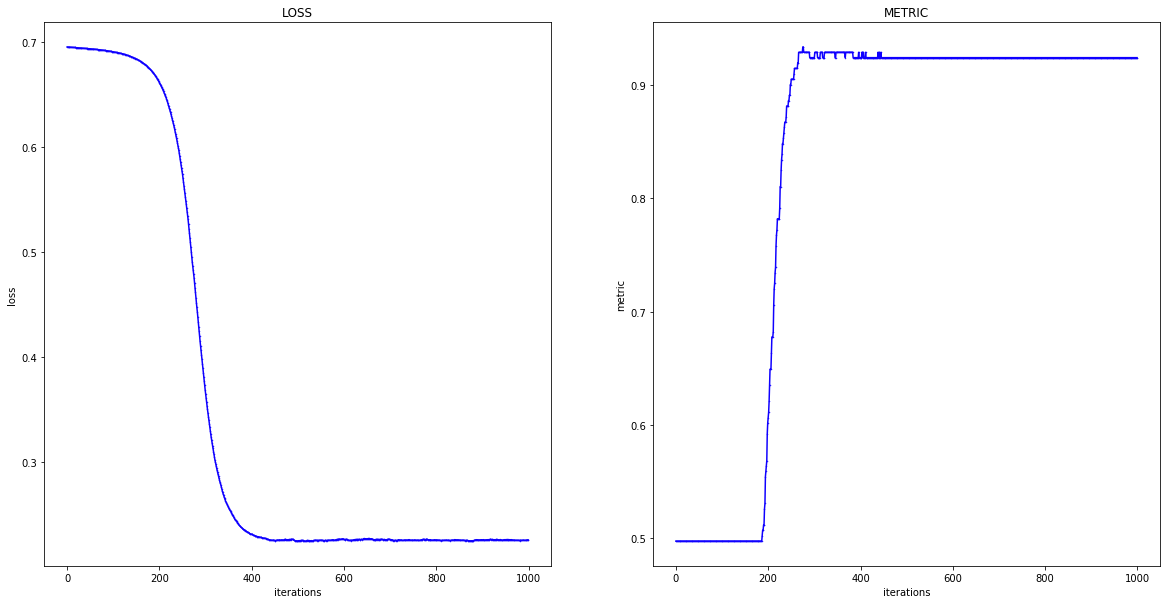

In [14]:
loss = nn.history['loss']
metric = nn.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

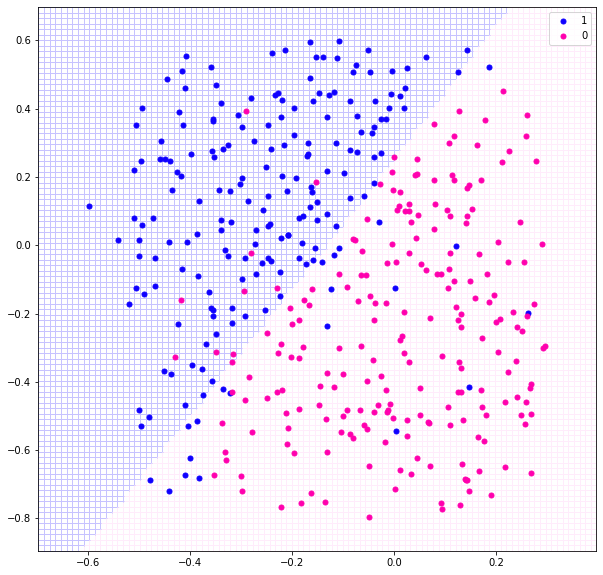

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, np.min(X[:,1])-0.1, np.max(X[:,1])+0.1])
u = np.linspace(np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, 100)
v = np.linspace(np.min(X[:,1])-0.1, np.max(X[:,1])+0.1, 100)
z = []
for i in range(100):
    for j in range(100):
        z.append([u[i], v[j]])
z = np.array(z)
w = (nn.predict(z)[:,0]>0.5).astype(int)
nn_pos = np.where(w == 1)[0]
nn_neg = np.where(w == 0)[0]
ax.plot(z[nn_pos,0], z[nn_pos,1], marker='+', color='#C7C3FF', markersize=10, linestyle='')
ax.plot(z[nn_neg,0], z[nn_neg,1], marker='+', color='#FFECFB', markersize=10, linestyle='')
pos = np.where(Y[:,0] == 1)[0]
neg = np.where(Y[:,0] == 0)[0]
ax.plot(X[pos,0], X[pos,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='1') 
ax.plot(X[neg,0], X[neg,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='0')
ax.legend()